# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [8]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 4)

[1/100][0/14]
- D_loss : 0.6327 / G_loss : 1.4096
- D(x) : 0.7378 / D(G(z1)) : 0.2711 / D(G(z2)) : 0.2507
[1/100][1/14]
- D_loss : 0.8384 / G_loss : 1.3856
- D(x) : 0.5927 / D(G(z1)) : 0.2511 / D(G(z2)) : 0.2566
[1/100][2/14]
- D_loss : 0.8720 / G_loss : 1.3174
- D(x) : 0.5787 / D(G(z1)) : 0.2607 / D(G(z2)) : 0.2734
[1/100][3/14]
- D_loss : 0.6681 / G_loss : 1.3213
- D(x) : 0.7301 / D(G(z1)) : 0.2881 / D(G(z2)) : 0.2726
[1/100][4/14]
- D_loss : 0.7725 / G_loss : 1.3516
- D(x) : 0.6610 / D(G(z1)) : 0.2832 / D(G(z2)) : 0.2672
[1/100][5/14]
- D_loss : 0.7905 / G_loss : 1.3616
- D(x) : 0.6293 / D(G(z1)) : 0.2616 / D(G(z2)) : 0.2615
[1/100][6/14]
- D_loss : 0.7400 / G_loss : 1.3028
- D(x) : 0.6741 / D(G(z1)) : 0.2794 / D(G(z2)) : 0.2782
[1/100][7/14]
- D_loss : 0.6851 / G_loss : 1.3605
- D(x) : 0.7128 / D(G(z1)) : 0.2805 / D(G(z2)) : 0.2626
[1/100][8/14]
- D_loss : 0.5946 / G_loss : 1.4716
- D(x) : 0.7486 / D(G(z1)) : 0.2545 / D(G(z2)) : 0.2354
[1/100][9/14]
- D_loss : 0.6481 / G_loss : 1.5

[6/100][8/14]
- D_loss : 0.6054 / G_loss : 1.5800
- D(x) : 0.7144 / D(G(z1)) : 0.2187 / D(G(z2)) : 0.2081
[6/100][9/14]
- D_loss : 0.7320 / G_loss : 1.5009
- D(x) : 0.6325 / D(G(z1)) : 0.2167 / D(G(z2)) : 0.2240
[6/100][10/14]
- D_loss : 0.6805 / G_loss : 1.4379
- D(x) : 0.6769 / D(G(z1)) : 0.2320 / D(G(z2)) : 0.2385
[6/100][11/14]
- D_loss : 0.7166 / G_loss : 1.4830
- D(x) : 0.6512 / D(G(z1)) : 0.2181 / D(G(z2)) : 0.2275
[6/100][12/14]
- D_loss : 0.6740 / G_loss : 1.4390
- D(x) : 0.6779 / D(G(z1)) : 0.2305 / D(G(z2)) : 0.2378
[6/100][13/14]
- D_loss : 0.7484 / G_loss : 1.3493
- D(x) : 0.6516 / D(G(z1)) : 0.2478 / D(G(z2)) : 0.2602
[7/100][0/14]
- D_loss : 0.6596 / G_loss : 1.3656
- D(x) : 0.7096 / D(G(z1)) : 0.2565 / D(G(z2)) : 0.2564
[7/100][1/14]
- D_loss : 0.7134 / G_loss : 1.3369
- D(x) : 0.6995 / D(G(z1)) : 0.2786 / D(G(z2)) : 0.2642
[7/100][2/14]
- D_loss : 0.6376 / G_loss : 1.4827
- D(x) : 0.7429 / D(G(z1)) : 0.2742 / D(G(z2)) : 0.2303
[7/100][3/14]
- D_loss : 0.5637 / G_loss :

[12/100][2/14]
- D_loss : 0.8235 / G_loss : 1.2272
- D(x) : 0.6516 / D(G(z1)) : 0.3107 / D(G(z2)) : 0.2947
[12/100][3/14]
- D_loss : 0.8186 / G_loss : 1.2356
- D(x) : 0.6488 / D(G(z1)) : 0.3046 / D(G(z2)) : 0.2945
[12/100][4/14]
- D_loss : 0.8120 / G_loss : 1.2153
- D(x) : 0.6746 / D(G(z1)) : 0.3205 / D(G(z2)) : 0.3044
[12/100][5/14]
- D_loss : 0.9993 / G_loss : 1.1854
- D(x) : 0.5476 / D(G(z1)) : 0.2976 / D(G(z2)) : 0.3099
[12/100][6/14]
- D_loss : 0.9522 / G_loss : 1.0665
- D(x) : 0.6022 / D(G(z1)) : 0.3356 / D(G(z2)) : 0.3496
[12/100][7/14]
- D_loss : 0.7403 / G_loss : 1.1674
- D(x) : 0.7285 / D(G(z1)) : 0.3299 / D(G(z2)) : 0.3177
[12/100][8/14]
- D_loss : 0.7083 / G_loss : 1.2639
- D(x) : 0.7234 / D(G(z1)) : 0.3052 / D(G(z2)) : 0.2866
[12/100][9/14]
- D_loss : 0.9704 / G_loss : 1.1521
- D(x) : 0.5906 / D(G(z1)) : 0.3277 / D(G(z2)) : 0.3243
[12/100][10/14]
- D_loss : 0.8497 / G_loss : 1.1860
- D(x) : 0.6397 / D(G(z1)) : 0.3080 / D(G(z2)) : 0.3127
[12/100][11/14]
- D_loss : 0.8395 / 

[17/100][10/14]
- D_loss : 0.8014 / G_loss : 1.2546
- D(x) : 0.6856 / D(G(z1)) : 0.3213 / D(G(z2)) : 0.2870
[17/100][11/14]
- D_loss : 0.8205 / G_loss : 1.3233
- D(x) : 0.6356 / D(G(z1)) : 0.2861 / D(G(z2)) : 0.2680
[17/100][12/14]
- D_loss : 0.8112 / G_loss : 1.3210
- D(x) : 0.6320 / D(G(z1)) : 0.2751 / D(G(z2)) : 0.2688
[17/100][13/14]
- D_loss : 0.7504 / G_loss : 1.2836
- D(x) : 0.6867 / D(G(z1)) : 0.2921 / D(G(z2)) : 0.2806
[18/100][0/14]
- D_loss : 1.0402 / G_loss : 1.2014
- D(x) : 0.5258 / D(G(z1)) : 0.2922 / D(G(z2)) : 0.3032
[18/100][1/14]
- D_loss : 0.8898 / G_loss : 1.1666
- D(x) : 0.6207 / D(G(z1)) : 0.3092 / D(G(z2)) : 0.3144
[18/100][2/14]
- D_loss : 0.8501 / G_loss : 1.1391
- D(x) : 0.6505 / D(G(z1)) : 0.3228 / D(G(z2)) : 0.3226
[18/100][3/14]
- D_loss : 0.7510 / G_loss : 1.1557
- D(x) : 0.7279 / D(G(z1)) : 0.3383 / D(G(z2)) : 0.3170
[18/100][4/14]
- D_loss : 0.7172 / G_loss : 1.2177
- D(x) : 0.7423 / D(G(z1)) : 0.3303 / D(G(z2)) : 0.2992
[18/100][5/14]
- D_loss : 0.8854 

[23/100][4/14]
- D_loss : 0.8963 / G_loss : 1.2102
- D(x) : 0.6159 / D(G(z1)) : 0.3179 / D(G(z2)) : 0.3031
[23/100][5/14]
- D_loss : 0.8676 / G_loss : 1.1942
- D(x) : 0.6245 / D(G(z1)) : 0.3130 / D(G(z2)) : 0.3074
[23/100][6/14]
- D_loss : 0.7000 / G_loss : 1.2299
- D(x) : 0.7379 / D(G(z1)) : 0.3166 / D(G(z2)) : 0.2983
[23/100][7/14]
- D_loss : 0.7553 / G_loss : 1.2658
- D(x) : 0.6822 / D(G(z1)) : 0.3000 / D(G(z2)) : 0.2870
[23/100][8/14]
- D_loss : 0.6833 / G_loss : 1.2879
- D(x) : 0.7290 / D(G(z1)) : 0.2978 / D(G(z2)) : 0.2824
[23/100][9/14]
- D_loss : 0.6058 / G_loss : 1.3503
- D(x) : 0.7646 / D(G(z1)) : 0.2777 / D(G(z2)) : 0.2631
[23/100][10/14]
- D_loss : 0.7489 / G_loss : 1.3730
- D(x) : 0.6517 / D(G(z1)) : 0.2567 / D(G(z2)) : 0.2571
[23/100][11/14]
- D_loss : 0.5880 / G_loss : 1.3123
- D(x) : 0.7739 / D(G(z1)) : 0.2763 / D(G(z2)) : 0.2717
[23/100][12/14]
- D_loss : 0.6489 / G_loss : 1.3183
- D(x) : 0.7203 / D(G(z1)) : 0.2666 / D(G(z2)) : 0.2692
[23/100][13/14]
- D_loss : 0.7228 

[28/100][12/14]
- D_loss : 0.6153 / G_loss : 1.4018
- D(x) : 0.7332 / D(G(z1)) : 0.2578 / D(G(z2)) : 0.2476
[28/100][13/14]
- D_loss : 0.8896 / G_loss : 1.3791
- D(x) : 0.5587 / D(G(z1)) : 0.2429 / D(G(z2)) : 0.2530
[29/100][0/14]
- D_loss : 0.5339 / G_loss : 1.4105
- D(x) : 0.7878 / D(G(z1)) : 0.2526 / D(G(z2)) : 0.2449
[29/100][1/14]
- D_loss : 0.7198 / G_loss : 1.4024
- D(x) : 0.6678 / D(G(z1)) : 0.2597 / D(G(z2)) : 0.2492
[29/100][2/14]
- D_loss : 0.8510 / G_loss : 1.3568
- D(x) : 0.5726 / D(G(z1)) : 0.2376 / D(G(z2)) : 0.2587
[29/100][3/14]
- D_loss : 0.6473 / G_loss : 1.3708
- D(x) : 0.7033 / D(G(z1)) : 0.2488 / D(G(z2)) : 0.2550
[29/100][4/14]
- D_loss : 0.8354 / G_loss : 1.2979
- D(x) : 0.5930 / D(G(z1)) : 0.2543 / D(G(z2)) : 0.2746
[29/100][5/14]
- D_loss : 0.7183 / G_loss : 1.2906
- D(x) : 0.6758 / D(G(z1)) : 0.2707 / D(G(z2)) : 0.2763
[29/100][6/14]
- D_loss : 0.8234 / G_loss : 1.2244
- D(x) : 0.6291 / D(G(z1)) : 0.2915 / D(G(z2)) : 0.2952
[29/100][7/14]
- D_loss : 0.9690 / 

[34/100][6/14]
- D_loss : 1.1217 / G_loss : 0.8375
- D(x) : 0.5942 / D(G(z1)) : 0.4383 / D(G(z2)) : 0.4399
[34/100][7/14]
- D_loss : 1.7132 / G_loss : 0.8281
- D(x) : 0.3317 / D(G(z1)) : 0.4218 / D(G(z2)) : 0.4451
[34/100][8/14]
- D_loss : 1.5165 / G_loss : 0.7825
- D(x) : 0.4119 / D(G(z1)) : 0.4384 / D(G(z2)) : 0.4640
[34/100][9/14]
- D_loss : 1.2930 / G_loss : 0.7701
- D(x) : 0.5368 / D(G(z1)) : 0.4683 / D(G(z2)) : 0.4702
[34/100][10/14]
- D_loss : 1.2392 / G_loss : 0.8140
- D(x) : 0.5617 / D(G(z1)) : 0.4647 / D(G(z2)) : 0.4505
[34/100][11/14]
- D_loss : 1.3154 / G_loss : 0.9062
- D(x) : 0.4657 / D(G(z1)) : 0.4029 / D(G(z2)) : 0.4103
[34/100][12/14]
- D_loss : 1.3151 / G_loss : 0.8740
- D(x) : 0.4835 / D(G(z1)) : 0.4239 / D(G(z2)) : 0.4241
[34/100][13/14]
- D_loss : 1.2702 / G_loss : 0.8971
- D(x) : 0.4839 / D(G(z1)) : 0.3991 / D(G(z2)) : 0.4152
[35/100][0/14]
- D_loss : 1.3892 / G_loss : 0.8542
- D(x) : 0.4387 / D(G(z1)) : 0.4094 / D(G(z2)) : 0.4329
[35/100][1/14]
- D_loss : 1.7242 

[40/100][0/14]
- D_loss : 1.1853 / G_loss : 0.6692
- D(x) : 0.5892 / D(G(z1)) : 0.4722 / D(G(z2)) : 0.5153
[40/100][1/14]
- D_loss : 1.3786 / G_loss : 0.6825
- D(x) : 0.4844 / D(G(z1)) : 0.4671 / D(G(z2)) : 0.5093
[40/100][2/14]
- D_loss : 1.5689 / G_loss : 0.6148
- D(x) : 0.4822 / D(G(z1)) : 0.5506 / D(G(z2)) : 0.5468
[40/100][3/14]
- D_loss : 1.7509 / G_loss : 0.5751
- D(x) : 0.4459 / D(G(z1)) : 0.5943 / D(G(z2)) : 0.5673
[40/100][4/14]
- D_loss : 1.5399 / G_loss : 0.6680
- D(x) : 0.5088 / D(G(z1)) : 0.5660 / D(G(z2)) : 0.5169
[40/100][5/14]
- D_loss : 2.1556 / G_loss : 0.8341
- D(x) : 0.2341 / D(G(z1)) : 0.4726 / D(G(z2)) : 0.4402
[40/100][6/14]
- D_loss : 1.5782 / G_loss : 0.9132
- D(x) : 0.3685 / D(G(z1)) : 0.4230 / D(G(z2)) : 0.4083
[40/100][7/14]
- D_loss : 1.6314 / G_loss : 0.8577
- D(x) : 0.3696 / D(G(z1)) : 0.4407 / D(G(z2)) : 0.4342
[40/100][8/14]
- D_loss : 1.5658 / G_loss : 0.8383
- D(x) : 0.3853 / D(G(z1)) : 0.4356 / D(G(z2)) : 0.4423
[40/100][9/14]
- D_loss : 1.3090 / G_

[45/100][8/14]
- D_loss : 1.0667 / G_loss : 1.0720
- D(x) : 0.5309 / D(G(z1)) : 0.3419 / D(G(z2)) : 0.3449
[45/100][9/14]
- D_loss : 1.0034 / G_loss : 1.0385
- D(x) : 0.5743 / D(G(z1)) : 0.3506 / D(G(z2)) : 0.3567
[45/100][10/14]
- D_loss : 0.8832 / G_loss : 1.0613
- D(x) : 0.6510 / D(G(z1)) : 0.3545 / D(G(z2)) : 0.3488
[45/100][11/14]
- D_loss : 0.8428 / G_loss : 1.0914
- D(x) : 0.6651 / D(G(z1)) : 0.3456 / D(G(z2)) : 0.3379
[45/100][12/14]
- D_loss : 0.7687 / G_loss : 1.1954
- D(x) : 0.6785 / D(G(z1)) : 0.3084 / D(G(z2)) : 0.3054
[45/100][13/14]
- D_loss : 0.8299 / G_loss : 1.1459
- D(x) : 0.6494 / D(G(z1)) : 0.3217 / D(G(z2)) : 0.3206
[46/100][0/14]
- D_loss : 0.8139 / G_loss : 1.0980
- D(x) : 0.6928 / D(G(z1)) : 0.3518 / D(G(z2)) : 0.3370
[46/100][1/14]
- D_loss : 1.0300 / G_loss : 1.0783
- D(x) : 0.5542 / D(G(z1)) : 0.3419 / D(G(z2)) : 0.3442
[46/100][2/14]
- D_loss : 0.8659 / G_loss : 1.1188
- D(x) : 0.6347 / D(G(z1)) : 0.3274 / D(G(z2)) : 0.3298
[46/100][3/14]
- D_loss : 0.8776 

[51/100][2/14]
- D_loss : 1.0712 / G_loss : 0.9117
- D(x) : 0.5882 / D(G(z1)) : 0.4088 / D(G(z2)) : 0.4039
[51/100][3/14]
- D_loss : 1.0157 / G_loss : 0.9233
- D(x) : 0.6260 / D(G(z1)) : 0.4158 / D(G(z2)) : 0.3984
[51/100][4/14]
- D_loss : 1.1856 / G_loss : 0.9167
- D(x) : 0.5296 / D(G(z1)) : 0.4162 / D(G(z2)) : 0.4006
[51/100][5/14]
- D_loss : 0.9942 / G_loss : 0.9528
- D(x) : 0.6298 / D(G(z1)) : 0.4066 / D(G(z2)) : 0.3871
[51/100][6/14]
- D_loss : 1.3234 / G_loss : 0.9451
- D(x) : 0.4346 / D(G(z1)) : 0.3768 / D(G(z2)) : 0.3913
[51/100][7/14]
- D_loss : 1.0987 / G_loss : 0.8989
- D(x) : 0.5635 / D(G(z1)) : 0.4022 / D(G(z2)) : 0.4085
[51/100][8/14]
- D_loss : 1.0210 / G_loss : 0.8860
- D(x) : 0.6241 / D(G(z1)) : 0.4164 / D(G(z2)) : 0.4139
[51/100][9/14]
- D_loss : 1.1787 / G_loss : 0.8025
- D(x) : 0.5590 / D(G(z1)) : 0.4436 / D(G(z2)) : 0.4506
[51/100][10/14]
- D_loss : 1.1304 / G_loss : 0.7854
- D(x) : 0.5989 / D(G(z1)) : 0.4544 / D(G(z2)) : 0.4595
[51/100][11/14]
- D_loss : 1.3480 / 

[56/100][10/14]
- D_loss : 1.3626 / G_loss : 0.6896
- D(x) : 0.5238 / D(G(z1)) : 0.5041 / D(G(z2)) : 0.5035
[56/100][11/14]
- D_loss : 1.4996 / G_loss : 0.6581
- D(x) : 0.4652 / D(G(z1)) : 0.5149 / D(G(z2)) : 0.5200
[56/100][12/14]
- D_loss : 1.4136 / G_loss : 0.7369
- D(x) : 0.4639 / D(G(z1)) : 0.4693 / D(G(z2)) : 0.4812
[56/100][13/14]
- D_loss : 1.3070 / G_loss : 0.7119
- D(x) : 0.5282 / D(G(z1)) : 0.4834 / D(G(z2)) : 0.4924
[57/100][0/14]
- D_loss : 1.6020 / G_loss : 0.6975
- D(x) : 0.3876 / D(G(z1)) : 0.4750 / D(G(z2)) : 0.4993
[57/100][1/14]
- D_loss : 1.3140 / G_loss : 0.6366
- D(x) : 0.5598 / D(G(z1)) : 0.5159 / D(G(z2)) : 0.5307
[57/100][2/14]
- D_loss : 1.4492 / G_loss : 0.6938
- D(x) : 0.4697 / D(G(z1)) : 0.4943 / D(G(z2)) : 0.5014
[57/100][3/14]
- D_loss : 1.3606 / G_loss : 0.6600
- D(x) : 0.5361 / D(G(z1)) : 0.5175 / D(G(z2)) : 0.5187
[57/100][4/14]
- D_loss : 1.3502 / G_loss : 0.7469
- D(x) : 0.4887 / D(G(z1)) : 0.4642 / D(G(z2)) : 0.4755
[57/100][5/14]
- D_loss : 1.4740 

[62/100][4/14]
- D_loss : 1.4501 / G_loss : 0.6431
- D(x) : 0.4965 / D(G(z1)) : 0.5231 / D(G(z2)) : 0.5275
[62/100][5/14]
- D_loss : 1.5146 / G_loss : 0.6804
- D(x) : 0.4491 / D(G(z1)) : 0.5062 / D(G(z2)) : 0.5083
[62/100][6/14]
- D_loss : 1.4347 / G_loss : 0.6751
- D(x) : 0.4993 / D(G(z1)) : 0.5172 / D(G(z2)) : 0.5106
[62/100][7/14]
- D_loss : 1.4190 / G_loss : 0.6862
- D(x) : 0.5048 / D(G(z1)) : 0.5169 / D(G(z2)) : 0.5052
[62/100][8/14]
- D_loss : 1.5160 / G_loss : 0.7467
- D(x) : 0.4283 / D(G(z1)) : 0.4811 / D(G(z2)) : 0.4756
[62/100][9/14]
- D_loss : 1.3480 / G_loss : 0.8269
- D(x) : 0.4717 / D(G(z1)) : 0.4441 / D(G(z2)) : 0.4388
[62/100][10/14]
- D_loss : 1.3560 / G_loss : 0.8002
- D(x) : 0.4717 / D(G(z1)) : 0.4494 / D(G(z2)) : 0.4506
[62/100][11/14]
- D_loss : 1.4774 / G_loss : 0.7617
- D(x) : 0.4367 / D(G(z1)) : 0.4725 / D(G(z2)) : 0.4683
[62/100][12/14]
- D_loss : 1.2760 / G_loss : 0.8316
- D(x) : 0.5001 / D(G(z1)) : 0.4374 / D(G(z2)) : 0.4365
[62/100][13/14]
- D_loss : 1.5071 

[67/100][12/14]
- D_loss : 1.3435 / G_loss : 0.7669
- D(x) : 0.5030 / D(G(z1)) : 0.4729 / D(G(z2)) : 0.4677
[67/100][13/14]
- D_loss : 1.4095 / G_loss : 0.7415
- D(x) : 0.4768 / D(G(z1)) : 0.4811 / D(G(z2)) : 0.4793
[68/100][0/14]
- D_loss : 1.4203 / G_loss : 0.7169
- D(x) : 0.4850 / D(G(z1)) : 0.4929 / D(G(z2)) : 0.4913
[68/100][1/14]
- D_loss : 1.3810 / G_loss : 0.7181
- D(x) : 0.5019 / D(G(z1)) : 0.4918 / D(G(z2)) : 0.4908
[68/100][2/14]
- D_loss : 1.3398 / G_loss : 0.7535
- D(x) : 0.5026 / D(G(z1)) : 0.4732 / D(G(z2)) : 0.4732
[68/100][3/14]
- D_loss : 1.4646 / G_loss : 0.7323
- D(x) : 0.4517 / D(G(z1)) : 0.4808 / D(G(z2)) : 0.4839
[68/100][4/14]
- D_loss : 1.2804 / G_loss : 0.7188
- D(x) : 0.5550 / D(G(z1)) : 0.4914 / D(G(z2)) : 0.4901
[68/100][5/14]
- D_loss : 1.3500 / G_loss : 0.7269
- D(x) : 0.5096 / D(G(z1)) : 0.4849 / D(G(z2)) : 0.4852
[68/100][6/14]
- D_loss : 1.4401 / G_loss : 0.7689
- D(x) : 0.4416 / D(G(z1)) : 0.4578 / D(G(z2)) : 0.4660
[68/100][7/14]
- D_loss : 1.3939 / 

[73/100][6/14]
- D_loss : 1.3958 / G_loss : 0.7284
- D(x) : 0.4781 / D(G(z1)) : 0.4802 / D(G(z2)) : 0.4838
[73/100][7/14]
- D_loss : 1.4195 / G_loss : 0.7009
- D(x) : 0.4806 / D(G(z1)) : 0.4948 / D(G(z2)) : 0.4968
[73/100][8/14]
- D_loss : 1.3239 / G_loss : 0.7138
- D(x) : 0.5187 / D(G(z1)) : 0.4847 / D(G(z2)) : 0.4910
[73/100][9/14]
- D_loss : 1.3811 / G_loss : 0.7060
- D(x) : 0.4996 / D(G(z1)) : 0.4937 / D(G(z2)) : 0.4947
[73/100][10/14]
- D_loss : 1.3569 / G_loss : 0.6938
- D(x) : 0.5191 / D(G(z1)) : 0.5019 / D(G(z2)) : 0.5008
[73/100][11/14]
- D_loss : 1.4056 / G_loss : 0.7273
- D(x) : 0.4748 / D(G(z1)) : 0.4817 / D(G(z2)) : 0.4841
[73/100][12/14]
- D_loss : 1.4338 / G_loss : 0.7196
- D(x) : 0.4619 / D(G(z1)) : 0.4824 / D(G(z2)) : 0.4879
[73/100][13/14]
- D_loss : 1.4124 / G_loss : 0.6974
- D(x) : 0.4866 / D(G(z1)) : 0.4967 / D(G(z2)) : 0.4993
[74/100][0/14]
- D_loss : 1.3522 / G_loss : 0.6992
- D(x) : 0.5191 / D(G(z1)) : 0.4991 / D(G(z2)) : 0.4982
[74/100][1/14]
- D_loss : 1.4013 

[79/100][0/14]
- D_loss : 1.3756 / G_loss : 0.6978
- D(x) : 0.5153 / D(G(z1)) : 0.5055 / D(G(z2)) : 0.5006
[79/100][1/14]
- D_loss : 1.3867 / G_loss : 0.6909
- D(x) : 0.5119 / D(G(z1)) : 0.5085 / D(G(z2)) : 0.5036
[79/100][2/14]
- D_loss : 1.3666 / G_loss : 0.7126
- D(x) : 0.5071 / D(G(z1)) : 0.4936 / D(G(z2)) : 0.4931
[79/100][3/14]
- D_loss : 1.3713 / G_loss : 0.6971
- D(x) : 0.5140 / D(G(z1)) : 0.5015 / D(G(z2)) : 0.5013
[79/100][4/14]
- D_loss : 1.2887 / G_loss : 0.7027
- D(x) : 0.5511 / D(G(z1)) : 0.4958 / D(G(z2)) : 0.4977
[79/100][5/14]
- D_loss : 1.3786 / G_loss : 0.6837
- D(x) : 0.5153 / D(G(z1)) : 0.5078 / D(G(z2)) : 0.5078
[79/100][6/14]
- D_loss : 1.4355 / G_loss : 0.6754
- D(x) : 0.4924 / D(G(z1)) : 0.5128 / D(G(z2)) : 0.5110
[79/100][7/14]
- D_loss : 1.4030 / G_loss : 0.6772
- D(x) : 0.5126 / D(G(z1)) : 0.5161 / D(G(z2)) : 0.5101
[79/100][8/14]
- D_loss : 1.3991 / G_loss : 0.6797
- D(x) : 0.5146 / D(G(z1)) : 0.5160 / D(G(z2)) : 0.5084
[79/100][9/14]
- D_loss : 1.5341 / G_

[84/100][8/14]
- D_loss : 1.4120 / G_loss : 0.6725
- D(x) : 0.4976 / D(G(z1)) : 0.5073 / D(G(z2)) : 0.5118
[84/100][9/14]
- D_loss : 1.3203 / G_loss : 0.6466
- D(x) : 0.5685 / D(G(z1)) : 0.5257 / D(G(z2)) : 0.5253
[84/100][10/14]
- D_loss : 1.4798 / G_loss : 0.6618
- D(x) : 0.4716 / D(G(z1)) : 0.5134 / D(G(z2)) : 0.5173
[84/100][11/14]
- D_loss : 1.3850 / G_loss : 0.6780
- D(x) : 0.5069 / D(G(z1)) : 0.5023 / D(G(z2)) : 0.5092
[84/100][12/14]
- D_loss : 1.4546 / G_loss : 0.6195
- D(x) : 0.5066 / D(G(z1)) : 0.5363 / D(G(z2)) : 0.5392
[84/100][13/14]
- D_loss : 1.3747 / G_loss : 0.6309
- D(x) : 0.5434 / D(G(z1)) : 0.5317 / D(G(z2)) : 0.5333
[85/100][0/14]
- D_loss : 1.3282 / G_loss : 0.6390
- D(x) : 0.5667 / D(G(z1)) : 0.5297 / D(G(z2)) : 0.5286
[85/100][1/14]
- D_loss : 1.4272 / G_loss : 0.6193
- D(x) : 0.5257 / D(G(z1)) : 0.5416 / D(G(z2)) : 0.5390
[85/100][2/14]
- D_loss : 1.4274 / G_loss : 0.6403
- D(x) : 0.5095 / D(G(z1)) : 0.5266 / D(G(z2)) : 0.5277
[85/100][3/14]
- D_loss : 1.3971 

[90/100][2/14]
- D_loss : 1.2579 / G_loss : 0.7709
- D(x) : 0.5357 / D(G(z1)) : 0.4670 / D(G(z2)) : 0.4634
[90/100][3/14]
- D_loss : 1.3040 / G_loss : 0.7655
- D(x) : 0.5127 / D(G(z1)) : 0.4683 / D(G(z2)) : 0.4658
[90/100][4/14]
- D_loss : 1.3033 / G_loss : 0.7812
- D(x) : 0.5052 / D(G(z1)) : 0.4590 / D(G(z2)) : 0.4587
[90/100][5/14]
- D_loss : 1.3264 / G_loss : 0.7666
- D(x) : 0.5002 / D(G(z1)) : 0.4669 / D(G(z2)) : 0.4656
[90/100][6/14]
- D_loss : 1.3632 / G_loss : 0.7817
- D(x) : 0.4754 / D(G(z1)) : 0.4594 / D(G(z2)) : 0.4587
[90/100][7/14]
- D_loss : 1.3370 / G_loss : 0.7738
- D(x) : 0.4908 / D(G(z1)) : 0.4619 / D(G(z2)) : 0.4622
[90/100][8/14]
- D_loss : 1.3271 / G_loss : 0.7646
- D(x) : 0.4986 / D(G(z1)) : 0.4664 / D(G(z2)) : 0.4664
[90/100][9/14]
- D_loss : 1.2703 / G_loss : 0.7783
- D(x) : 0.5236 / D(G(z1)) : 0.4598 / D(G(z2)) : 0.4603
[90/100][10/14]
- D_loss : 1.4438 / G_loss : 0.7650
- D(x) : 0.4426 / D(G(z1)) : 0.4638 / D(G(z2)) : 0.4663
[90/100][11/14]
- D_loss : 1.2786 / 

[95/100][10/14]
- D_loss : 1.4277 / G_loss : 0.7117
- D(x) : 0.4749 / D(G(z1)) : 0.4911 / D(G(z2)) : 0.4939
[95/100][11/14]
- D_loss : 1.3652 / G_loss : 0.7153
- D(x) : 0.5048 / D(G(z1)) : 0.4906 / D(G(z2)) : 0.4916
[95/100][12/14]
- D_loss : 1.3781 / G_loss : 0.6994
- D(x) : 0.5036 / D(G(z1)) : 0.4965 / D(G(z2)) : 0.4995
[95/100][13/14]
- D_loss : 1.4307 / G_loss : 0.7198
- D(x) : 0.4678 / D(G(z1)) : 0.4854 / D(G(z2)) : 0.4889
[96/100][0/14]
- D_loss : 1.3949 / G_loss : 0.7159
- D(x) : 0.4833 / D(G(z1)) : 0.4839 / D(G(z2)) : 0.4916
[96/100][1/14]
- D_loss : 1.3388 / G_loss : 0.7319
- D(x) : 0.5007 / D(G(z1)) : 0.4738 / D(G(z2)) : 0.4823
[96/100][2/14]
- D_loss : 1.4357 / G_loss : 0.6695
- D(x) : 0.4876 / D(G(z1)) : 0.5088 / D(G(z2)) : 0.5143
[96/100][3/14]
- D_loss : 1.3676 / G_loss : 0.6945
- D(x) : 0.5125 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5012
[96/100][4/14]
- D_loss : 1.4076 / G_loss : 0.6950
- D(x) : 0.4901 / D(G(z1)) : 0.4982 / D(G(z2)) : 0.5010
[96/100][5/14]
- D_loss : 1.3943 

# Graph

In [9]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

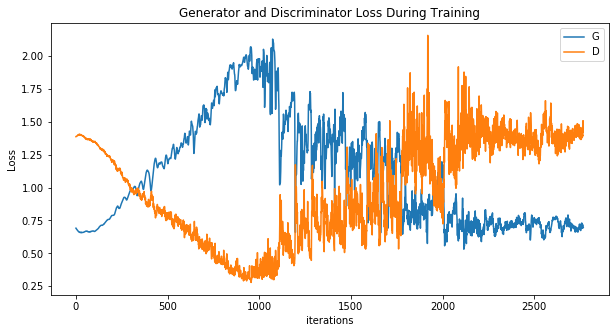

In [10]:
plot_train_loss()

# Animation

In [11]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

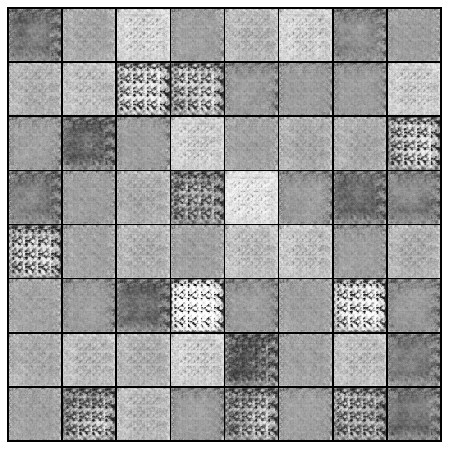

In [12]:
animate_gen_imgs()

# Anomaly Loss

In [13]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_DualPhaseSteel"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [14]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [15]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1618.0732  Sum_of_z : -9.6422
[200]	 Ano_loss : 1496.4865  Sum_of_z : 12.2572
[400]	 Ano_loss : 1478.7303  Sum_of_z : 14.8150
picture  2
[0]	 Ano_loss : 1322.7000  Sum_of_z : 14.8213
[200]	 Ano_loss : 1192.4346  Sum_of_z : 19.3939
[400]	 Ano_loss : 1184.8013  Sum_of_z : 16.8275
picture  3
[0]	 Ano_loss : 1946.8558  Sum_of_z : 16.7693
[200]	 Ano_loss : 1861.0551  Sum_of_z : 10.2282
[400]	 Ano_loss : 1846.9060  Sum_of_z : 7.4370
picture  4
[0]	 Ano_loss : 1166.9353  Sum_of_z : 7.4344
[200]	 Ano_loss : 1103.1071  Sum_of_z : 10.0085
[400]	 Ano_loss : 1100.5774  Sum_of_z : 10.3642
picture  5
[0]	 Ano_loss : 2194.5110  Sum_of_z : 10.3351
[200]	 Ano_loss : 2144.9492  Sum_of_z : 5.9391
[400]	 Ano_loss : 2139.6033  Sum_of_z : 5.2408
picture  6
[0]	 Ano_loss : 1247.4171  Sum_of_z : 5.5193
[200]	 Ano_loss : 1149.6360  Sum_of_z : 6.3930
[400]	 Ano_loss : 1148.0905  Sum_of_z : 9.1620
picture  7
[0]	 Ano_loss : 1134.2330  Sum_of_z : 9.0418
[200]	 Ano_loss : 1098.3142  Sum_

---

# 이상 픽셀 수 확인 함수

In [16]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

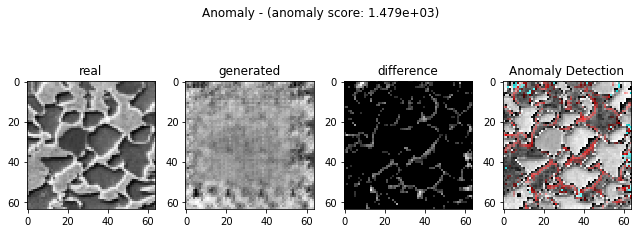

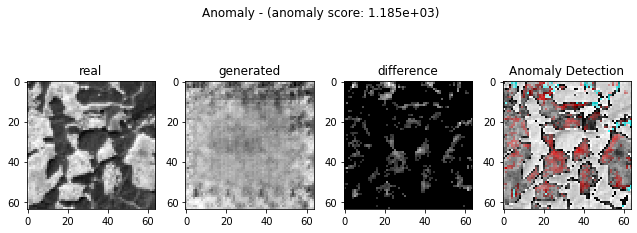

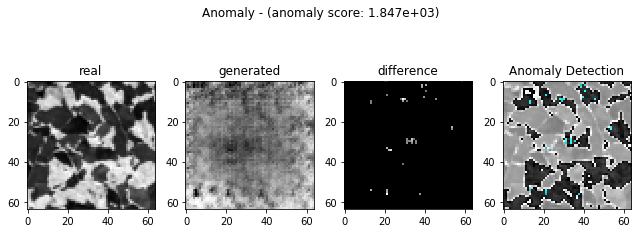

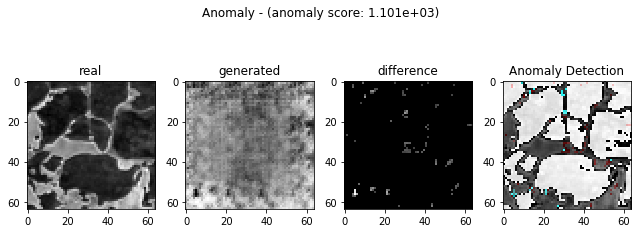

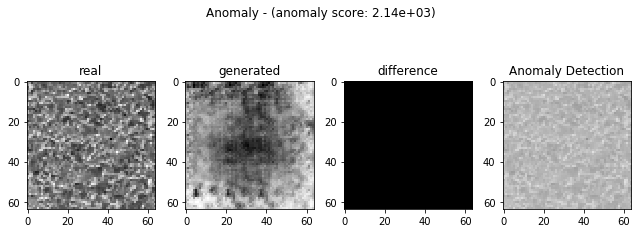

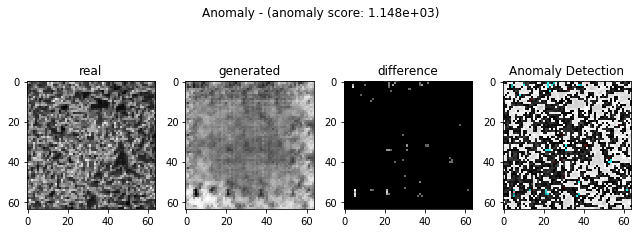

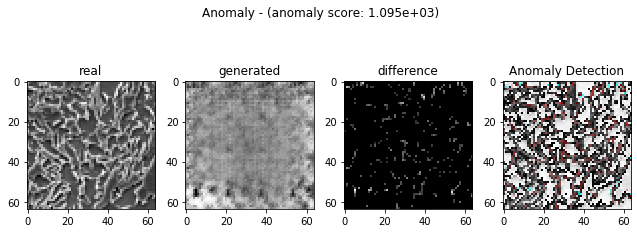

In [18]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [19]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.17382812 0.19335938 0.00952148 0.02539062 0.         0.01464844
 0.07226562]


In [20]:
print(sum(diff_fraction)/len(diff_fraction))

0.06985909598214286


---

# 분산 추출

In [ ]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# 모델 저장 및 읽기

In [ ]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [ ]:
save_pretrained()

In [ ]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [ ]:
load_pretrained()

In [ ]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [ ]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [ ]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

In [ ]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# anomaly detection 이미지 추출

In [ ]:
anomaly_imgs

# 이미지 저장 함수

In [ ]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [ ]:
save_imgs("./anomaly_imgs", anomaly_imgs)

---

# 티타늄(Ti64) 상대 밀도 계산

In [ ]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)